<a href="https://colab.research.google.com/github/Sep-eg/career_search/blob/main/career_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI BootCamp Section2 Project

## 학생의 공부환경과 진로희망

학창 시절 학기 초가 되면 늘 하던 조사가 있습니다. 바로 진로희망 조사입니다.

분명한 자신만의 꿈, 혹은 계획을 가지고 진로희망 조사에 임하는 학생들도 있겠지만,

사실 많은 학생들은 자신이 하고 싶은 것이 무엇인지 모르고 그저 남들이 많이 적는 것,

혹은 사회적으로 인정받거나 돈을 많이 번다고 알려진 진로를 희망하는 경우가 많습니다.

저는 그런 때를 떠올리며 이런 생각을 하였습니다. 학생들이 자기가 하고 싶은 것을 좀 더 쉽게 알 수 있다면,

하다못해 커다란 방향성 하나만이라도 결정하는 데 도움을 줄 수 있다면 얼마나 좋을까?

저는 그래서 학생들의 주변 환경, 성적 등에 관련된 정보를 찾아보았고, MDIS에서 제공하는 '초중고 사교육비 조사' 데이터를

이용하여 학생들의 사교육, 주변 환경 등을 통해 어떠한 진로를 희망하면 좋을지 예측해보기로 하였습니다.

In [ ]:
# !pip install pdpbox
# !pip install eli5

     |████████████████████████████████| 34.0 MB 36 kB/s 
     |████████████████████████████████| 13.1 MB 6.6 kB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.1-py3-none-any.whl size=35758225 sha256=2af1266bc08b64bf5d690d8def4fb2c74e6c224157b0877c6ee9f7dcb7385175
  Stored in directory: /root/.cache/pip/wheels/f4/d0/1a/b80035625c53131f52906a6fc4dd690d8efd2bf8af6a4015eb
Successfully built pdpbox
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


     |████████████████████████████████| 106 kB 5.5 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.metrics import accuracy_score, f1_score, classification_report, plot_confusion_matrix, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from pdpbox.pdp import pdp_isolate, pdp_plot
from xgboost import XGBClassifier, plot_importance

In [ ]:
df = pd.read_csv('data.csv', encoding='CP949')

### EDA

먼저 해당 데이터는 초, 중, 고등학교에 대한 데이터를 모두 포함하고 있습니다.

저는 이 중에서 본격적으로 진로에 대한 고민이 심화되는 시점이라 생각되는 고등학생의 데이터만을 이용할 것입니다.

이를 위해 사용할 특성은 '학교급구분' 특성입니다. 또한 제가 예측할 타겟이 되는 특성은

학생들의 진학 시 희망 전공이 담긴 '진학희망대학전공영역' 특성입니다.

- 학교급구분
  
  1 초등학고 / 2 중학교 / 3 일반고 / 4 특성화고
  
- 진학희망 대학전공 영역
  
  1 교육계열 / 2 예술 및 인문학 / 3 사회과학, 언론 및 정보학 / 4 경영, 행정 및 법
  
  5 자연과학, 수학 및 통계학 / 6 정보통신기술 / 7 공학, 제조 및 건설 / 8 농림어업 및 수의학
  
  9 보건 및 복지 / 10 서비스 / 11 기타

In [ ]:
df.head()

,지역구분,학교급구분,학년,방과후학교참여여부(유상+무상),방과후학교참여시간,방과후학교총금액,초등방과후보육프로그램,특기적성프로그램,교과프로그램,EBS교재비,어학연수비,국내연수,해외연수,사교육참여시간,일반교과사교육목적1,일반교과사교육목적2,일반교과사교육시간,예체능사교육목적1,예체능사교육목적2,예체능사교육시간,취업관련사교육시간,사교육비총금액,일반교과,국어,영어,수학,사회·과학,논술·독서교실·글쓰기·독서토론,컴퓨터(소프트웨어/코딩 포함),제2외국어·한문 등,일반교과개인과외,일반교과그룹과외,일반교과학원수강,일반교과방문학습지,일반교과유료인터넷및통신강좌등,"예체능, 취미·교양",음악,미술,체육,취미·교양,예체능개인과외,예체능그룹과외,예체능학원수강,예체능방문수업및기타,취업관련,진로진학학습상담(컨설팅)참여여부,진로진학학습상담(컨설팅)비용,진로진학학습상담(컨설팅)횟수,학생성별,총자녀수,출생순위,학생성적,부의연령,부의교육정도,모의연령,모의교육정도,부모의경제활동,월평균가구소득,진학희망고등학교유형,진학희망대학전공영역,가중치
0,1,1,1,1,0.666667,11.104718,0.0,11.104718,0.000000,0.0,0.0,0.0,0.0,12.0,2.0,5.0,10.0,2.0,5.0,2.0,0.0,1282.853616,1188.699222,188.308788,529.618465,282.463181,0.000000,188.308788,0.0,0.000000,0.0,0.0,1188.699222,0.000000,0.0,94.154394,0.000000,0.0,94.154394,0.0,0.000000,0.00000,94.154394,0.0,0.0,2,0.0,0,1,2,2,NaN,3.0,62.0,2.0,51.0,3.0,8,1.0,NaN,87.970333
1,1,1,1,1,0.666667,12.585347,0.0,12.585347,0.000000,0.0,0.0,0.0,0.0,3.0,5.0,3.0,1.0,2.0,NaN,2.0,0.0,510.787587,240.093704,41.192547,41.192547,41.192547,37.661758,44.723337,0.0,34.130968,0.0,0.0,0.000000,240.093704,0.0,270.693882,117.692992,0.0,153.000890,0.0,117.692992,153.00089,0.000000,0.0,0.0,2,0.0,0,1,3,1,NaN,2.0,51.0,2.0,61.0,1.0,4,2.0,NaN,160.363220
2,1,1,1,1,0.666667,13.325661,0.0,0.000000,13.325661,0.0,0.0,0.0,0.0,13.0,2.0,1.0,3.0,2.0,1.0,10.0,0.0,429.579422,117.692992,41.192547,35.307898,41.192547,0.000000,0.000000,0.0,0.000000,0.0,0.0,35.307898,82.385095,0.0,311.886430,164.770189,0.0,147.116240,0.0,0.000000,0.00000,311.886430,0.0,0.0,2,0.0,0,1,2,2,NaN,3.0,51.0,3.0,51.0,3.0,5,3.0,NaN,154.927179
3,1,1,1,1,0.666667,13.695818,0.0,13.695818,0.000000,0.0,0.0,0.0,0.0,11.0,2.0,5.0,8.0,2.0,NaN,3.0,0.0,1094.544828,906.236041,0.000000,529.618465,200.078087,0.000000,176.539488,0.0,0.000000,0.0,0.0,906.236041,0.000000,0.0,188.308788,0.000000,0.0,188.308788,0.0,0.000000,0.00000,188.308788,0.0,0.0,2,0.0,0,1,3,1,NaN,3.0,51.0,2.0,51.0,1.0,7,4.0,NaN,85.855662
4,1,1,1,1,0.666667,14.065976,0.0,14.065976,0.000000,0.0,0.0,0.0,0.0,7.0,NaN,NaN,0.0,2.0,NaN,7.0,0.0,200.078087,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,200.078087,0.000000,0.0,200.078087,0.0,0.000000,0.00000,200.078087,0.0,0.0,2,0.0,0,1,2,1,NaN,3.0,51.0,3.0,41.0,1.0,5,1.0,NaN,221.172239


In [ ]:
df.shape

(75315, 61)

In [ ]:
# 결측치 확인 / 각 학교급에 따라 추가 문항이 있는 경우가 있음
df.isna().sum()

지역구분                    0
학교급구분                   0
학년                      0
방과후학교참여여부(유상+무상)        0
방과후학교참여시간               0
                    ...  
부모의경제활동               336
월평균가구소득                 0
진학희망고등학교유형          34712
진학희망대학전공영역          40603
가중치                     0
Length: 61, dtype: int64

In [ ]:
# 데이터 타입 확인
df.dtypes

지역구분                  int64
학교급구분                 int64
학년                    int64
방과후학교참여여부(유상+무상)      int64
방과후학교참여시간           float64
                     ...   
부모의경제활동             float64
월평균가구소득               int64
진학희망고등학교유형          float64
진학희망대학전공영역          float64
가중치                 float64
Length: 61, dtype: object

In [ ]:
# 기본 통계치 확인
df.describe()

,지역구분,학교급구분,학년,방과후학교참여여부(유상+무상),방과후학교참여시간,방과후학교총금액,초등방과후보육프로그램,특기적성프로그램,교과프로그램,EBS교재비,어학연수비,국내연수,해외연수,사교육참여시간,일반교과사교육목적1,일반교과사교육목적2,일반교과사교육시간,예체능사교육목적1,예체능사교육목적2,예체능사교육시간,취업관련사교육시간,사교육비총금액,일반교과,국어,영어,수학,사회·과학,논술·독서교실·글쓰기·독서토론,컴퓨터(소프트웨어/코딩 포함),제2외국어·한문 등,일반교과개인과외,일반교과그룹과외,일반교과학원수강,일반교과방문학습지,일반교과유료인터넷및통신강좌등,"예체능, 취미·교양",음악,미술,체육,취미·교양,예체능개인과외,예체능그룹과외,예체능학원수강,예체능방문수업및기타,취업관련,진로진학학습상담(컨설팅)참여여부,진로진학학습상담(컨설팅)비용,진로진학학습상담(컨설팅)횟수,학생성별,총자녀수,출생순위,학생성적,부의연령,부의교육정도,모의연령,모의교육정도,부모의경제활동,월평균가구소득,진학희망고등학교유형,진학희망대학전공영역,가중치
count,75315.000000,75315.000000,75315.000000,75315.000000,75315.000000,75315.000000,75315.000000,75315.000000,75315.000000,75315.000000,75315.000000,75315.000000,75315.000000,75315.000000,40548.000000,30755.000000,75315.000000,23690.000000,12105.000000,75315.000000,75315.000000,75315.000000,75315.000000,75315.000000,75315.000000,75315.000000,75315.000000,75315.000000,75315.000000,75315.000000,75315.000000,75315.000000,75315.000000,75315.000000,75315.000000,75315.000000,75315.000000,75315.000000,75315.000000,75315.000000,75315.000000,75315.000000,75315.000000,75315.000000,75315.000000,75315.000000,75315.000000,75315.000000,75315.000000,75315.000000,75315.000000,34712.000000,71262.000000,71262.000000,72498.000000,72498.000000,74979.000000,75315.000000,40603.000000,34712.000000,75315.000000
mean,2.643604,2.268685,2.405762,1.494696,2.270827,14.413818,0.000688,5.267210,9.145920,3.596161,6.525609,0.376223,6.149386,6.064613,2.543479,3.608649,4.343362,2.411482,3.230153,1.653358,0.067893,385.060449,303.149821,31.985047,113.336977,125.015780,18.149637,9.167726,1.748095,3.746560,47.038703,28.945381,210.916318,8.458762,7.790658,77.379346,24.731818,15.764451,28.494974,8.388103,14.420834,5.388750,54.411410,3.158352,2.969356,1.975543,1.561926,0.118715,1.482547,2.171772,1.632384,3.180917,3.191210,43.446255,2.926426,41.794036,2.301391,4.415973,2.120065,6.198289,72.399987
std,0.964431,0.949469,1.310271,0.499975,3.413521,29.519186,0.085303,19.042673,20.669747,9.918362,121.484832,17.014225,119.655974,6.395364,1.101193,1.391822,5.519633,1.041559,1.552847,3.601339,0.838822,438.170034,404.578078,93.367671,164.594419,185.374698,74.694037,47.250477,21.000583,28.959457,179.879801,121.074979,336.384906,35.483220,43.272637,182.838162,106.505158,95.250907,93.226312,60.659236,104.993611,46.456960,139.004159,21.830081,42.582126,0.154465,16.086460,1.121112,0.499699,0.731961,0.722780,1.249376,0.583141,11.435106,0.541039,10.482116,0.949463,2.126259,1.958523,3.423580,69.370904
min,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,8.000000,1.000000,8.000000,1.000000,1.000000,1.000000,1.000000,3.216216
25%,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,1.000000,2.000000,1.000000,2.000000,3.000000,31.000000,3.000000,31.000000,1.000000,3.000000,1.000000,3.000000,32.320755
50%,3.000000,2.000000,2.000000,1.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2.000000,3.000000,1.666667,2.000000,3.000000,0.000000,0.000000,275.846648,119.933325,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000

In [ ]:
# 학교급 구분 특성 데이터 분포 확인
df['학교급구분'].value_counts()

3    28676
1    20512
2    20091
4     6036
Name: 학교급구분, dtype: int64

---
*고등학생에 해당하는 3, 4를 제외한 관측치를 제거하겠습니다.*

In [ ]:
df = df[(df['학교급구분']==3) | (df['학교급구분']==4)]

In [ ]:
df.shape

(34712, 61)

In [ ]:
# 결측치 다시 확인 / 진학희망고등학교유형 특성은 초등, 중학생에게만 해당하는 특성
df.isna().sum()

지역구분                    0
학교급구분                   0
학년                      0
방과후학교참여여부(유상+무상)        0
방과후학교참여시간               0
                    ...  
부모의경제활동               178
월평균가구소득                 0
진학희망고등학교유형          34712
진학희망대학전공영역              0
가중치                     0
Length: 61, dtype: int64

---
*고등학생에겐 필요없는 특성들을 제거하겠습니다.*

In [ ]:
df = df.drop(['초등방과후보육프로그램','진학희망고등학교유형'], axis=1)

In [ ]:
# 특성이 제대로 삭제되었는지 확인 / True
df.shape

(34712, 59)

In [ ]:
df.isna().sum()

지역구분                     0
학교급구분                    0
학년                       0
방과후학교참여여부(유상+무상)         0
방과후학교참여시간                0
방과후학교총금액                 0
특기적성프로그램                 0
교과프로그램                   0
EBS교재비                   0
어학연수비                    0
국내연수                     0
해외연수                     0
사교육참여시간                  0
일반교과사교육목적1           18007
일반교과사교육목적2           21997
일반교과사교육시간                0
예체능사교육목적1            29636
예체능사교육목적2            32279
예체능사교육시간                 0
취업관련사교육시간                0
사교육비총금액                  0
일반교과                     0
국어                       0
영어                       0
수학                       0
사회·과학                    0
논술·독서교실·글쓰기·독서토론         0
컴퓨터(소프트웨어/코딩 포함)         0
제2외국어·한문 등               0
일반교과개인과외                 0
일반교과그룹과외                 0
일반교과학원수강                 0
일반교과방문학습지                0
일반교과유료인터넷및통신강좌등          0
예체능, 취미·교양               0
음악                       0
미술                       0
체

---
제가 찾고자하는 결과는 자신의 방향성을 잘모르는 학생들에게 방향을 제시해 주는것이므로

교육 목적을 확실히 아는것과는 거리가 있습니다. 따라서 교육목적과 관련된 특성은 제거하겠습니다.

In [ ]:
df = df.drop(['일반교과사교육목적1', '일반교과사교육목적2', '예체능사교육목적1', '예체능사교육목적2'], axis = 1)
df.shape

(34712, 55)

In [ ]:
df[(df['부의연령'].isna() == True) & (df['부의교육정도'].isna() == True)].shape

(2110, 55)

In [ ]:
df[(df['모의연령'].isna() == True) & (df['모의교육정도'].isna() == True)].shape

(1427, 55)

---
부의연령, 부의교육정도 그리고 모의연령, 모의교육정도의 결측치는 각각 부, 모가 안계신 경우를 나타냅니다.

이는 교육, 진로적 측면에서 크게 영향을 미칠 수 있는 부분으로 생각되므로 버리지않고 0으로 대체하여 사용하겠습니다.

또한 부모의경제활동 특성의 결측치는 부모가 모두 안계신 경우로 이 역시 0으로 대체하여 사용하겠습니다.

In [ ]:
# 남은 결측치는 모두 0으로 대체 가능
df = df.fillna(0)

In [ ]:
# 결측치 처리 확인 / 0개 확인
df.isna().sum().sum()

0

다음으로 타겟데이터를 축소시키겠습니다.

제가 희망하는 결과는 세세한 전공의 희망보다는 학생이 자유롭게 선택하되 큰 틀의 방향만 정해주는 것입니다.

따라서 이공계열로 진학을 희망하는 학생을 1, 그렇지 않은 학생은 0으로 분류하도록 하겠습니다.

0. 기타
* 1 교육계열 / 2 예술 및 인문학 / 3 사회과학, 언론 및 정보학 / 4 경영, 행정 및 법 / 10 서비스 / 11 기타(아직 결정 안함, 진학 안함 등)
1. 이공계열
* 5 자연 과학, 수학 및 통계학 / 6 정보통신기술 / 7 공학, 제조 및 건설 / 8 농림어업 및 수의학 / 9 보건 및 복지

In [ ]:
df['진학희망대학전공영역'].value_counts()
# 0 -> 21599 / 1 -> 13113

2.0     5331
11.0    4692
7.0     4555
9.0     4256
10.0    3661
4.0     3201
1.0     2821
5.0     1960
3.0     1893
6.0     1879
8.0      463
Name: 진학희망대학전공영역, dtype: int64

In [ ]:
df['진학희망대학전공영역'] = df['진학희망대학전공영역'].replace([1,2,3,4,10,11],0).replace([5,6,7,8,9],1)

In [ ]:
# 정상분류 확인 / True
df['진학희망대학전공영역'].value_counts()

0.0    21599
1.0    13113
Name: 진학희망대학전공영역, dtype: int64

---
본격적으로 필요없는 특성을 지우고, 데이터를 다루기 편하도록 특성명을 변경하겠습니다.

In [ ]:
# 지역 특성은 분류 목적에 부합하지 않기 때문에 drop
df = df.drop('지역구분',axis = 1)

# 학교급구분은 이미 활용했으므로 drop
df = df.drop('학교급구분',axis = 1)

# 학년 특성은 분류 목적에 부합하지 않기 때문에 drop
df = df.drop('학년',axis = 1)

# 방과후학교참여여부(유상+무상) 특성은 참여시간으로 확인 가능 drop
df = df.drop('방과후학교참여여부(유상+무상)',axis = 1)

# 각각의 특성이 직접 미치는 영향을 살펴보기 위해 합계에 관한 특성 drop
df = df.drop(['어학연수비', '사교육참여시간', '사교육비총금액', '일반교과', '예체능, 취미·교양'],axis = 1)

# 가중치 특성 drop
df = df.drop('가중치',axis = 1)

# 특성명 변경
df = df.rename({'방과후학교참여시간':'after_school_time',
                '방과후학교총금액':'after_school_pay',
                '특기적성프로그램':'specialty_program',
                '교과프로그램':'subject_program',
                'EBS교재비':'EBS_textbook_pay',
                #'어학연수비':'language_train_pay',
                '국내연수':'domestic_train',
                '해외연수':'overseas_train',
                #'사교육참여시간':'private_edu_time',
                '일반교과사교육시간':'general_private_edu_time',
                '예체능사교육시간':'AMP_private_edu_time', # AMP(Art, Music, Physical)
                '취업관련사교육시간':'job_private_edu_time',
                #'사교육비총금액':'private_edu_pay',
                #'일반교과':'general_edu_pay',
                '국어':'korean_edu_pay',
                '영어':'english_edu_pay',
                '수학':'math_edu_pay',
                '사회·과학':'social_science_edu_pay',
                '논술·독서교실·글쓰기·독서토론':'essay_edu_pay',
                '컴퓨터(소프트웨어/코딩 포함)':'computer_edu_pay',
                '제2외국어·한문 등':'second_language_edu_pay',
                '일반교과개인과외':'general_personal_lesson_pay',
                '일반교과그룹과외':'general_group_lesson_pay',
                '일반교과학원수강':'general_academy_lesson_pay',
                '일반교과방문학습지':'general_study_paper_pay',
                '일반교과유료인터넷및통신강좌등':'general_e_learning_pay',
                #'예체능, 취미·교양':'AMP_hobby_edu_pay',
                '음악':'music_edu_pay',
                '미술':'art_edu_pay',
                '체육':'physical_edu_pay',
                '취미·교양':'hobby_edu_pay',
                '예체능개인과외':'AMP_personal_lesson_pay',
                '예체능그룹과외':'AMP_group_lesson_pay',
                '예체능학원수강':'AMP_academy_lesson_pay',
                '예체능방문수업및기타':'AMP_etc_edu_pay',
                '취업관련':'job_edu_pay',
                '진로진학학습상담(컨설팅)참여여부':'career_coach_participate',
                '진로진학학습상담(컨설팅)비용':'career_coach_pay',
                '진로진학학습상담(컨설팅)횟수':'career_coach_time',
                '학생성별':'gender',
                '총자녀수':'total_children',
                '출생순위':'birth_rank',
                '학생성적':'grade',
                '부의연령':'father_age',
                '부의교육정도':'father_edu',
                '모의연령':'mother_age',
                '모의교육정도':'mother_edu',
                '부모의경제활동':'parents_economic',
                '월평균가구소득':'household_income',
                '진학희망대학전공영역':'hope_major'}, axis = 'columns')

In [ ]:
# 특성 drop이 정상적으로 됐는지 확인 / True
df.shape

(34712, 45)

In [ ]:
# 특성명 변경이 정상적으로 됐는지 확인 / True
df.columns

Index(['after_school_time', 'after_school_pay', 'specialty_program',
       'subject_program', 'EBS_textbook_pay', 'domestic_train',
       'overseas_train', 'general_private_edu_time', 'AMP_private_edu_time',
       'job_private_edu_time', 'korean_edu_pay', 'english_edu_pay',
       'math_edu_pay', 'social_science_edu_pay', 'essay_edu_pay',
       'computer_edu_pay', 'second_language_edu_pay',
       'general_personal_lesson_pay', 'general_group_lesson_pay',
       'general_academy_lesson_pay', 'general_study_paper_pay',
       'general_e_learning_pay', 'music_edu_pay', 'art_edu_pay',
       'physical_edu_pay', 'hobby_edu_pay', 'AMP_personal_lesson_pay',
       'AMP_group_lesson_pay', 'AMP_academy_lesson_pay', 'AMP_etc_edu_pay',
       'job_edu_pay', 'career_coach_participate', 'career_coach_pay',
       'career_coach_time', 'gender', 'total_children', 'birth_rank', 'grade',
       'father_age', 'father_edu', 'mother_age', 'mother_edu',
       'parents_economic', 'household_income', '

### Data Wrangling

---
이제 각각의 특성과 타겟이 어떠한 분포를 보이는지 보기위해 데이터 랭글링과 시각화를 진행해 보겠습니다.

먼저 국어, 영어, 수학 혹은 컴퓨터 등의 교육을 받는것이 사회문화 영역이나 이공계열 선택에 영향을 끼치는지 확인해 보겠습니다.

In [ ]:
# hope major 특성을 target으로 저장
target = 'hope_major'

In [ ]:
# 희망진로 별 국어과목 교육비
df.groupby(target)['korean_edu_pay'].sum()

hope_major
0.0    933384.312267
1.0    678272.299122
Name: korean_edu_pay, dtype: float64

In [ ]:
# 희망진로 별 영어과목 교육비
df.groupby(target)['english_edu_pay'].sum()

hope_major
0.0    2.218077e+06
1.0    1.675779e+06
Name: english_edu_pay, dtype: float64

In [ ]:
# 희망진로 별 수학과목 교육비
df.groupby(target)['math_edu_pay'].sum()

hope_major
0.0    2.622236e+06
1.0    2.602361e+06
Name: math_edu_pay, dtype: float64

In [ ]:
# 희망진로 별 컴퓨터과목 교육비
df.groupby(target)['computer_edu_pay'].sum()

hope_major
0.0    18456.832086
1.0    30288.472262
Name: computer_edu_pay, dtype: float64

In [ ]:
pay_by_hope = pd.DataFrame(df.groupby(target)[['korean_edu_pay','english_edu_pay',
                                               'math_edu_pay','computer_edu_pay']].sum())
pay_by_hope

,korean_edu_pay,english_edu_pay,math_edu_pay,computer_edu_pay
hope_major,,,,
0.0,933384.312267,2.218077e+06,2.622236e+06,18456.832086
1.0,678272.299122,1.675779e+06,2.602361e+06,30288.472262


In [ ]:
pay_by_hope['count'] = [21599, 13113] # 1인당 교육비 계산을 위해 hope_major별 학생 수 추가

In [ ]:
pay_by_hope

,korean_edu_pay,english_edu_pay,math_edu_pay,computer_edu_pay,count
hope_major,,,,,
0.0,933384.312267,2.218077e+06,2.622236e+06,18456.832086,21599
1.0,678272.299122,1.675779e+06,2.602361e+06,30288.472262,13113


In [ ]:
# 각 과목별 1인당 교육비 계산
for column in pay_by_hope.columns[:5]:
    pay_by_hope[f'{column}_per_person'] = pay_by_hope[column]/pay_by_hope['count']
pay_by_hope

,korean_edu_pay,english_edu_pay,math_edu_pay,computer_edu_pay,count,korean_edu_pay_per_person,english_edu_pay_per_person,math_edu_pay_per_person,computer_edu_pay_per_person,count_per_person
hope_major,,,,,,,,,,
0.0,933384.312267,2.218077e+06,2.622236e+06,18456.832086,21599,43.214237,102.693489,121.405450,0.854523,1.0
1.0,678272.299122,1.675779e+06,2.602361e+06,30288.472262,13113,51.725181,127.795247,198.456567,2.309805,1.0


과목별 총합 교육비에서는 국어, 영어, 수학과목에 대하여 이공계열이 아닌 학생들이 더 많이 지출하는 것으로 보이지만,

1인당 교육비로 환산해 보았을때 모든 과목에 대하여 이공계열 희망 학생들이 더 많은 비용의 교육비를 지출하는 것으로 나타났습니다.

그중에서도 수학과 컴퓨터 과목에 1인당 지출비용은 이공계열 희망 학생이 아닌 학생들에 비해

수학은 약 1.63배, 컴퓨터는 약 2.7배로 국어, 영어 과목에 비해 더 높은 비율의 비용을 지불하고 있습니다.

---

다음으로는 부모님의 경제적배경이 학생들의 진로희망과도 연관성을 보이는지 파악해보겠습니다.

In [ ]:
pd.crosstab(df[target],df['household_income']) # 희망전공 가구소득 분포

household_income,1,2,3,4,5,6,7,8
hope_major,,,,,,,,
0.0,1927,2965,3595,3516,3402,1818,1294,3082
1.0,849,1586,2015,2258,2158,1231,954,2062


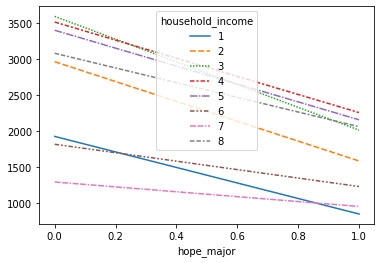

In [ ]:
hope_by_income = pd.crosstab(df[target],df['household_income'])
sns.lineplot(data = hope_by_income);

In [ ]:
# 각 칼럼별로 hope_major의 비율을 나타내는 칼럼 추가
for i in hope_by_income.columns:
    hope_by_income[f'{i}_ratio'] = hope_by_income[i]/hope_by_income[i].sum()
hope_by_income

household_income,1,2,3,4,5,6,7,8,1_ratio,2_ratio,3_ratio,4_ratio,5_ratio,6_ratio,7_ratio,8_ratio
hope_major,,,,,,,,,,,,,,,,
0.0,1927,2965,3595,3516,3402,1818,1294,3082,0.694164,0.651505,0.64082,0.608937,0.611871,0.596261,0.575623,0.599145
1.0,849,1586,2015,2258,2158,1231,954,2062,0.305836,0.348495,0.35918,0.391063,0.388129,0.403739,0.424377,0.400855


household_income특성은 가구의 월평균 소득수준을 나타내는 특성으로

**1 : 200만원 미만, 2 : 200 ~ 300만원 미만, 3 : 300 ~ 400만원 미만, 4 : 400 ~ 500만원 미만,**

**5 : 500 ~ 600만원 미만, 6 : 600 ~ 700만원 미만, 7 : 700 ~ 800만원 미만, 8 : 800만원 이상**

을 나타냅니다.

모든 구간에 걸쳐서 이공계열을 희망하는 학생은 그렇지 않은 학생에 비해 적은 숫자인 것을 확인 할 수 있었으나.

각 소득수준별 선택의 비율을 살펴본 결과 소득 수준이 증가할수록 이공계열을 희망하는 학생의 비율이 증가하는것 역시 확인되었습니다.

---

### 예비모델


여기까지 살펴 보았을때 저는 각각의 특성이 실제 전공 선택에 영향을 줄 수 있으며,

머신러닝을 통해 도움이 될만한 추천결과 모델을 만들 수 있겠다는 생각이 들었습니다.

머신러닝 모델을 만들기전 기본적인 베이스라인을 설정하겠습니다.

In [ ]:
# target데이터의 값 비율
df[target].value_counts(normalize = True)

0.0    0.622234
1.0    0.377766
Name: hope_major, dtype: float64

In [ ]:
# 타겟데이터 중 최빈값을 베이스라인 데이터로 저장
baseline_data = [df[target].mode()[0]] * len(df[target])

In [ ]:
# 베이스라인 정확도 확인
baseline_acc_score = accuracy_score(baseline_data, df[target])
print('baseline accuracy score:', baseline_acc_score)

baseline accuracy score: 0.6222343858031805


베이스라인은 타겟 데이터를 모두 최빈값인 0으로 예측할 경우의 정확도를 사용하겠습니다.

계산해본 결과 정확도는 약 **62.2%**을 보이고 있습니다.

---

In [ ]:
# train, validation, test 셋 분리
train, test = train_test_split(df, train_size = 0.8, stratify = df[target], random_state = 2)
train, val = train_test_split(train, train_size = 0.8, stratify = train[target], random_state = 2)

train.shape, val.shape, test.shape

((22215, 45), (5554, 45), (6943, 45))

In [ ]:
# 관측데이터와 타겟데이터 분리
X_train = train.drop(target, axis=1)
y_train = train[target]

X_val = val.drop(target, axis=1)
y_val = val[target]

X_test = test.drop(target, axis=1)
y_test = test[target]

본격적으로 모델을 만들기 전 랜덤포레스트를 사용한 모델로 기본적인 성능을 한번 파악해보겠습니다.

In [ ]:
# 데이터가 모두 숫자형이고 결측치가 없으므로 encoder, imputer 생략

rfc = RandomForestClassifier(random_state = 2)

rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=2, verbose=0,
                       warm_start=False)

train accuracy score: 0.9931577762772901
train report
               precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     13823
         1.0       1.00      0.99      0.99      8392

    accuracy                           0.99     22215
   macro avg       0.99      0.99      0.99     22215
weighted avg       0.99      0.99      0.99     22215



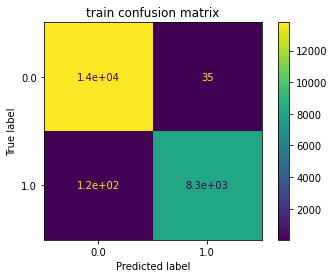

In [ ]:
print('train accuracy score:',rfc.score(X_train, y_train))
print('train report\n',classification_report(y_train, rfc.predict(X_train)))
# 실제로 분류된 데이터 분포 확인
plot_confusion_matrix(rfc, X_train, y_train);
plt.title('train confusion matrix');

validation accuracy score: 0.6647461289160965
validation report
               precision    recall  f1-score   support

         0.0       0.70      0.82      0.75      3456
         1.0       0.58      0.42      0.48      2098

    accuracy                           0.66      5554
   macro avg       0.64      0.62      0.62      5554
weighted avg       0.65      0.66      0.65      5554



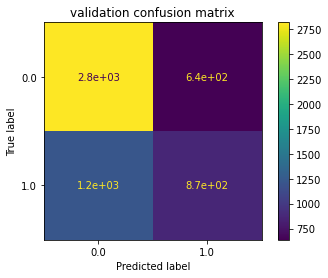

In [ ]:
print('validation accuracy score:',rfc.score(X_val, y_val))
print('validation report\n',classification_report(y_val, rfc.predict(X_val)))
# 실제로 분류된 데이터 분포 확인
plot_confusion_matrix(rfc, X_val, y_val);
plt.title('validation confusion matrix');

피쳐엔지니어링과 하이퍼 파라미터 튜닝을 거치지 않고 기본적인 랜덤포레스트모델을 이용하여 검증데이터셋을 예측해본 결과

정확도는 약 66.5%로 베이스라인인 62.2%에 비해 높은 모습을 보이지만,

혼동행렬을 보았을때 이공계열학생을 그렇지 않은 경우로 예측한 경우가 많은것으로 나타났습니다.

이는 타겟데이터의 불균형과 학습데이터셋에 과적합된 영향이 크게 작용한것으로 보이며

이를 감안하여 피쳐엔지니어링과 하이퍼 파라미터 튜닝을 진행하겠습니다.

---

### Feature Engineering

In [ ]:
def engineering(df):
    
    # 이공계열에서 많은 비용을 지불한 수학, 컴퓨터교육 비용을 합산한 특성 생성
    df['sci_engin_pay'] = df['math_edu_pay'] + df['computer_edu_pay']
    
    # 비이공계열에서 많은 비용을 지불한 국어, 영어교육 비용을 합산한 특성 생성
    df['social_culture_pay'] = df['korean_edu_pay'] + df['english_edu_pay']
    
    # 월 수입대비 교육비 합산의 비율을 계산하는 특성 생성
    df['sci_engin_per_income'] = df['sci_engin_pay'] / df['household_income']
    df['social_culture_per_income'] = df['social_culture_pay'] / df['household_income']
    
    return df

X_train = engineering(X_train)
X_val = engineering(X_val)
X_test = engineering(X_test)

### make Models

In [ ]:
xg_model = XGBClassifier()

xgb_param_grid = {'max_depth': randint(1, 10), 
                  'scale_pos_weight': randint(1, 10),
                  'subsample': uniform(0, 1),
                  'colsample_bytree': uniform(0, 1)}

fit_params={"early_stopping_rounds":20,
                "eval_metric" : 'error', 
                "eval_set" : [[X_val, y_val]]
               }

xgb_random = RandomizedSearchCV(
    estimator = xg_model,
    param_distributions = xgb_param_grid,
    n_iter = 50,
    scoring='f1_micro', # recall 넣으면 모두 1로 예측해서 데이터 불균형을 염두에둔 f1스코어 사용
    verbose=1,
    n_jobs=-1, 
    cv = 6, 
)

xgb_random.fit(X_train,y_train, **fit_params)

Fitting 6 folds for each of 50 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  9.8min finished


[0]	validation_0-error:0.354519
Will train until validation_0-error hasn't improved in 20 rounds.
[1]	validation_0-error:0.340115
[2]	validation_0-error:0.334534
[3]	validation_0-error:0.332193
[4]	validation_0-error:0.330212
[5]	validation_0-error:0.330393
[6]	validation_0-error:0.328592
[7]	validation_0-error:0.328412
[8]	validation_0-error:0.327152
[9]	validation_0-error:0.32319
[10]	validation_0-error:0.32301
[11]	validation_0-error:0.32211
[12]	validation_0-error:0.32301
[13]	validation_0-error:0.324811
[14]	validation_0-error:0.325531
[15]	validation_0-error:0.324451
[16]	validation_0-error:0.323371
[17]	validation_0-error:0.324271
[18]	validation_0-error:0.325891
[19]	validation_0-error:0.324271
[20]	validation_0-error:0.32301
[21]	validation_0-error:0.325531
[22]	validation_0-error:0.32211
[23]	validation_0-error:0.32103
[24]	validation_0-error:0.32319
[25]	validation_0-error:0.32157
[26]	validation_0-error:0.323371
[27]	validation_0-error:0.32265
[28]	validation_0-error:0.3237

RandomizedSearchCV(cv=6, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, sc...
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7efbd2b99050>,
                                        'scale_pos_w

In [ ]:
y_pred=xgb_random.predict(X_val)

              precision    recall  f1-score   support

         0.0       0.70      0.87      0.78      3456
         1.0       0.64      0.40      0.49      2098

    accuracy                           0.69      5554
   macro avg       0.67      0.63      0.63      5554
weighted avg       0.68      0.69      0.67      5554



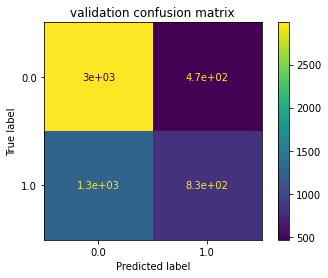

In [ ]:
print(classification_report(y_val, y_pred))
plot_confusion_matrix(xgb_random, X_val, y_val);
plt.title('validation confusion matrix');

In [ ]:
pipe = make_pipeline(
    RandomForestClassifier(random_state=2)
)
dists = {
    'randomforestclassifier__max_depth': [5, 10, 15, 20, None],
    'randomforestclassifier__min_samples_leaf': randint(1, 10),
    'randomforestclassifier__max_features': uniform(0, 1),
    'randomforestclassifier__n_estimators': randint(50, 500),
}
clf = RandomizedSearchCV(
    pipe,
    param_distributions=dists,
    n_iter=10, # 시간너무 오래걸려서 조정...
    cv=3, # 시간너무 오래걸려서 조정...
    scoring='f1_micro',
    verbose=1,
    n_jobs=-1
)

clf.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  4.4min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('randomforestclassifier',
                                              RandomForestClassifier(bootstrap=True,
                                                                     ccp_alpha=0.0,
                                                                     class_weight=None,
                                                                     criterion='gini',
                                                                     max_depth=None,
                                                                     max_features='auto',
                                                                     max_leaf_nodes=None,
                                                                     max_samples=None,
                                                                     min_impurity_decrease=0.0,
                                           

In [ ]:
pipe = clf.best_estimator_

              precision    recall  f1-score   support

         0.0       0.70      0.86      0.77      3456
         1.0       0.62      0.38      0.47      2098

    accuracy                           0.68      5554
   macro avg       0.66      0.62      0.62      5554
weighted avg       0.67      0.68      0.66      5554



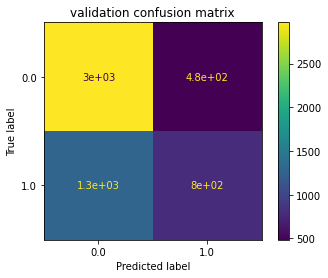

In [ ]:
print(classification_report(y_val, pipe.predict(X_val)))
plot_confusion_matrix(pipe, X_val, y_val);
plt.title('validation confusion matrix');

XGboost를 이용한 모델과 랜덤포레스트를 이용한 모델을 각각 랜덤서치CV를 통해 하이퍼파라미터 튜닝을 완료해 주었습니다.

그 결과 두 모델 모두 정확도는 약 0.68로 나타났지만, 부스팅을 이용한 모델이

가중치를 적용한 f1스코어에서 약 0.01, 그리고 재현율에서 약 0.02만큼 높은 성능을 보여주었기 때문에

부스팅 모델을 채용하고 임계치 조정을 하도록 하겠습니다.

In [ ]:
y_pred_proba = xgb_random.predict_proba(X_val)[:,1]

In [ ]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

In [ ]:
optimal_idx = np.argmax(tpr - fpr)
threshold = thresholds[optimal_idx]

In [ ]:
threshold

0.37712762

In [ ]:
y_pred = y_pred_proba >= threshold

In [ ]:
print(classification_report(y_val, y_pred))
print('validation confusion matrix\n', confusion_matrix(y_pred, y_val))

              precision    recall  f1-score   support

         0.0       0.77      0.64      0.70      3456
         1.0       0.54      0.69      0.60      2098

    accuracy                           0.66      5554
   macro avg       0.65      0.66      0.65      5554
weighted avg       0.68      0.66      0.66      5554

validation confusion matrix
 [[2210  659]
 [1246 1439]]


임계값 조정까지 거친 결과 정확도는 약 0.65로 소폭 감소하였지만,

이공계열 학생을 예측한 재현율은 0.41에서 0.69로 크게 오른 모습을 보였습니다.

마지막으로 최종 모델을 테스트셋에 적용해보겠습니다.

---

### test predict

In [ ]:
y_test_proba = xgb_random.predict_proba(X_test)[:,1]

In [ ]:
y_test_pred = y_test_proba >= threshold

In [ ]:
print(classification_report(y_test, y_test_pred))
print('test accuracy score:',accuracy_score(y_test, y_test_pred))
print('test confusion matrix\n', confusion_matrix(y_test_pred, y_test))

              precision    recall  f1-score   support

         0.0       0.76      0.62      0.68      4320
         1.0       0.52      0.67      0.58      2623

    accuracy                           0.64      6943
   macro avg       0.64      0.64      0.63      6943
weighted avg       0.66      0.64      0.64      6943

test accuracy score: 0.6373325651735561
test confusion matrix
 [[2663  861]
 [1657 1762]]


---
최종모델로 테스트해본 결과

정확도 : 약 63.7%

f1score : 약 0.64

재현율 : 약 0.68

의 성능으로 측정되었습니다. 이는 베이스라인에 비하여 정확도는 1.5%정도 상승한 수치이며

예비모델(rfc모델)에 비하여 f1score는 약 0.01 하락, 재현율은 약 0.26 상승한 수치입니다.

---

이제 실제로 어떤 특성들이 이러한 결과에 영향을 끼쳤는지 확인해 보겠습니다.

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

In [ ]:
permuter = PermutationImportance(
    xgb_random, # model
    scoring='recall', # metric
    n_iter=5, # 다른 random seed를 사용하여 5번 반복
    random_state=2
)

permuter.fit(X_val, y_val);

In [ ]:
feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()

social_culture_per_income     -0.018017
social_culture_pay            -0.007531
english_edu_pay               -0.006387
mother_age                    -0.002574
general_personal_lesson_pay   -0.002383
hobby_edu_pay                 -0.002097
father_edu                    -0.000953
total_children                -0.000572
AMP_etc_edu_pay               -0.000286
career_coach_time             -0.000286
essay_edu_pay                 -0.000191
domestic_train                 0.000000
AMP_group_lesson_pay           0.000000
overseas_train                 0.000000
computer_edu_pay               0.000191
general_academy_lesson_pay     0.000477
general_study_paper_pay        0.000477
career_coach_participate       0.000667
job_edu_pay                    0.000858
general_e_learning_pay         0.000953
job_private_edu_time           0.001239
general_group_lesson_pay       0.001430
career_coach_pay               0.001716
mother_edu                     0.002097
AMP_personal_lesson_pay        0.002193


조금 더 보기 편하게 표시하겠습니다.

In [ ]:
eli5.show_weights(
    permuter, 
    top=13, # 중요도가 0.01 이상이었던 상위 13개만 표시
    feature_names=feature_names
)

Weight,Feature
0.0381 ± 0.0227,gender
0.0355 ± 0.0110,AMP_private_edu_time
0.0226 ± 0.0043,sci_engin_pay
0.0224 ± 0.0063,subject_program
0.0150 ± 0.0023,sci_engin_per_income
0.0145 ± 0.0042,math_edu_pay
0.0131 ± 0.0067,AMP_academy_lesson_pay
0.0109 ± 0.0078,after_school_time
0.0079 ± 0.0068,EBS_textbook_pay
0.0077 ± 0.0041,art_edu_pay


각 특성의 중요도를 permuter를 통해 확인해본 결과

가장 큰 영향을 끼친 세 가지 특성은 **학생성별**, **예체능사교육시간**, **교과프로그램** 등으로 나타났습니다.

또한 학습에 거의 영향을 주지 못했다고 판단되는 특성이 17개로 나타났으며 해당 특성은 따로 분류해 놓겠습니다. 

In [ ]:
# permutation importance가 0이하인 특성명 선별
importance_o = pd.Series(permuter.feature_importances_, feature_names).sort_values()[:17].index
importance_o

Index(['social_culture_per_income', 'social_culture_pay', 'english_edu_pay',
       'mother_age', 'general_personal_lesson_pay', 'hobby_edu_pay',
       'father_edu', 'total_children', 'AMP_etc_edu_pay', 'career_coach_time',
       'essay_edu_pay', 'domestic_train', 'AMP_group_lesson_pay',
       'overseas_train', 'computer_edu_pay', 'general_academy_lesson_pay',
       'general_study_paper_pay'],
      dtype='object')

다음으로 중요하게 판단되었던 특성들이 실제 어떤 식으로 결과 예측에 영향을 주었는지 시각화해 보겠습니다.

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


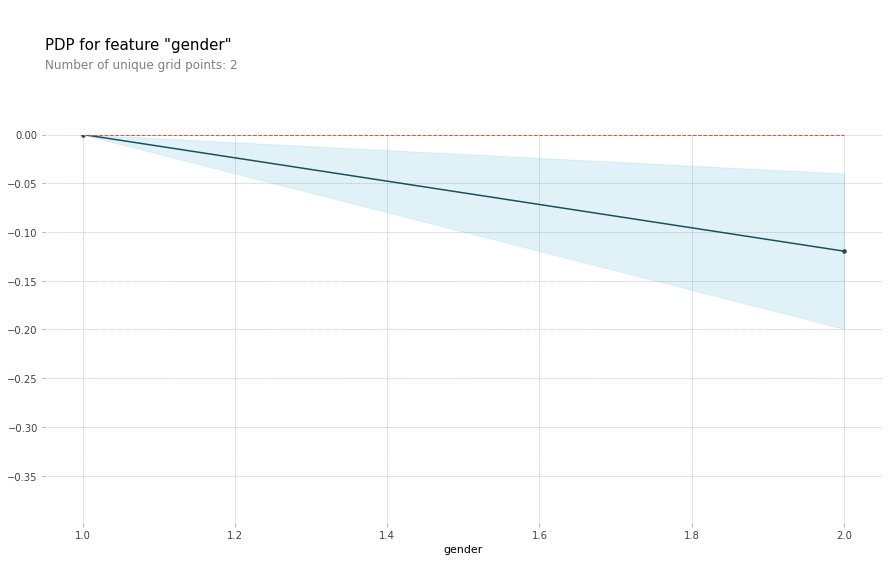

In [ ]:
features = ['gender', 'AMP_private_edu_time', 'subject_program']

isolated = pdp_isolate(
    model=xgb_random, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=features[0]
)
pdp_plot(isolated, feature_name=features[0]);

가장 영향을 많이 끼친 **학생성별** 특성은 여학생일 경우 이공계열 희망이 아닐 것이라 예측하는 모습을 보였습니다.

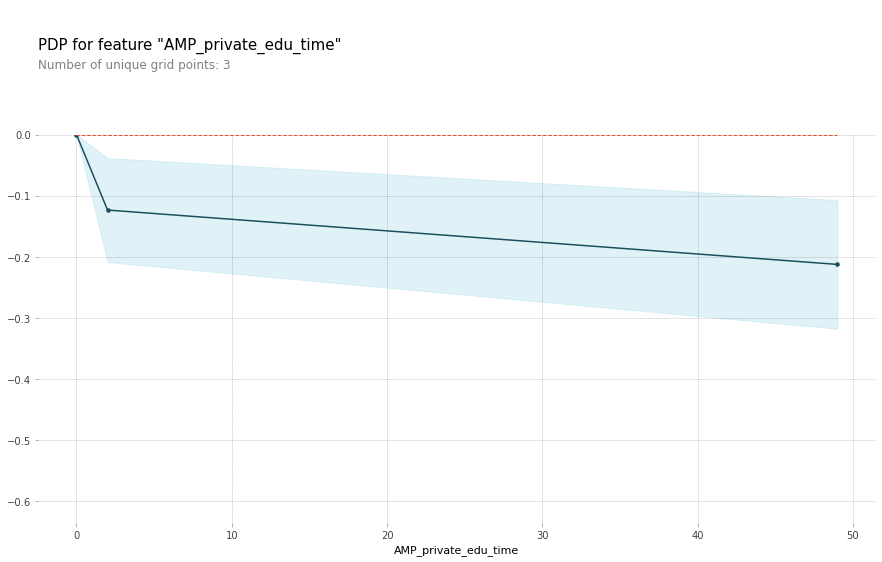

In [ ]:
isolated = pdp_isolate(
    model=xgb_random, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=features[1]
)
pdp_plot(isolated, feature_name=features[1]);

다음으로 **예체능사교육시간** 특성입니다. 해당 특성은 값이 증가할수록 이공계열을 희망할 확률이 점차 줄어드는 음의 선형관계를 보였습니다.

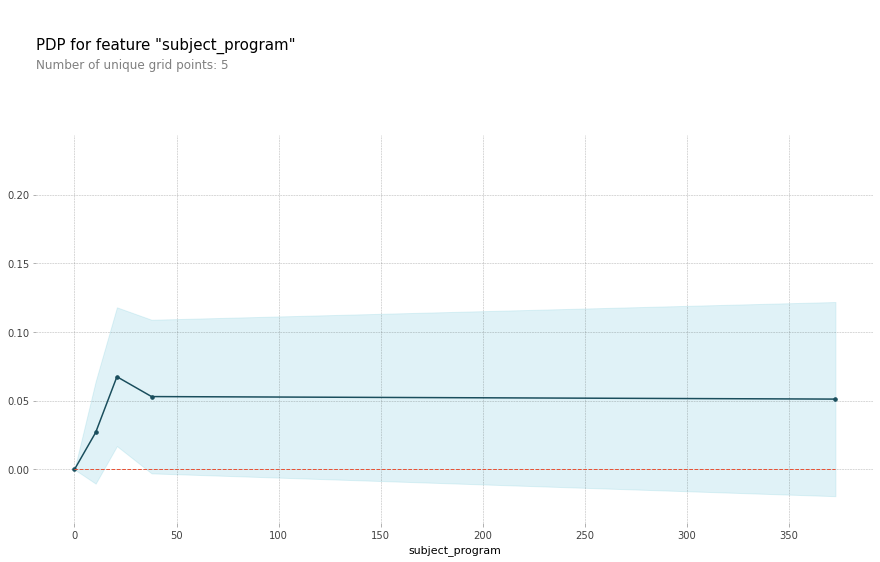

In [ ]:
isolated = pdp_isolate(
    model=xgb_random, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=features[2]
)
pdp_plot(isolated, feature_name=features[2]);

마지막으로 **교과프로그램** 특성입니다. 해당 특성은 값이 존재할때 이공계열을 희망할 가능성을 높이는 요소로 작용했습니다.

## 결론

제가 생각하는 이 모델의 한계점은 크게 두 가지입니다.

1. 타겟과 특성들의 인과관계
* 학생들이 타겟(이공계열, 혹은 이외의 계열)을 선택하였기 때문에 특성(각 과목별 사교육)을 실시하였을 수 있다.
* 학생의 선택과 무관하게 부모님, 선생님 등 주변 사람들로 인해 억지로 선택했을 수 있다.

2. 라벨로 존재하는 학생들이 추후 만족할지 못할지는 미지수이다.

다만, 연관 없어 보이는 다양한 관점, 환경을 통해 예측한 결과값은 그동안 생각하지 못한 새로운 선택지를 만들어 줄 수 있습니다.

결국 선택은 학생의 몫이기에 이 모델의 결과값이 방향을 정하지 못하고 고민 중인 학생들에게 하나의 선택지이자 이정표가 될 수 있을 것이라 기대합니다.